## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [2]:
import pandas as pd
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
path = '/home/jun/data/MIMIC/processed'
#path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark'
output_path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark/Figure3/'
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95


In [3]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,score_SERP2d,score_SERP7d,score_SERP30d
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1,16,21,16
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1,28,33,29
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4,18,20,17
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3,36,36,31
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0,32,36,31


In [4]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [5]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [6]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [7]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [8]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [9]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [10]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [11]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.047332185886402756 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 3.1246719360351562 seconds
AUC: 0.6782527320551448
AUPRC: 0.16653445799576483
Sensitivity: 0.5683972911963883
Specificity: 0.686449391988555
Score thresold: 0.041905087030353776
2.5 97.5


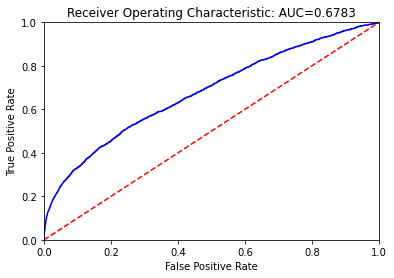

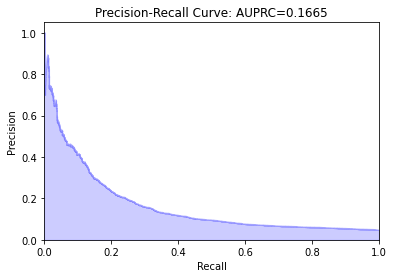

In [12]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 79.10067415237427 seconds
AUC: 0.6932743830270267
AUPRC: 0.1701833802641054
Sensitivity: 0.6325056433408578
Specificity: 0.6361990343347639
Score thresold: 0.04536741112510433
2.5 97.5


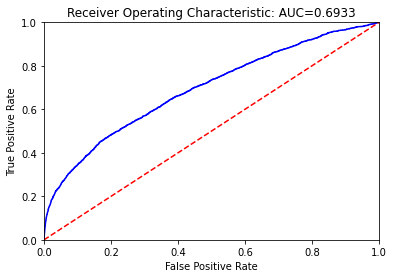

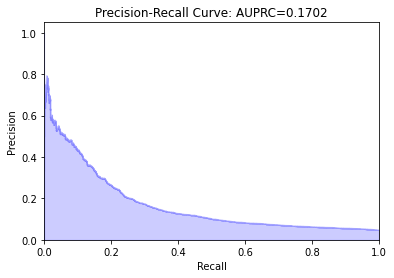

In [13]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 34.510735273361206 seconds
AUC: 0.6612857078557888
AUPRC: 0.154031844842356
Sensitivity: 0.6054176072234763
Specificity: 0.6236140915593705
Score thresold: 0.04333333333333333
2.5 97.5


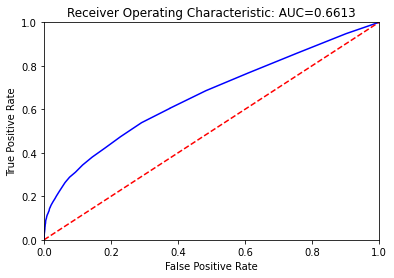

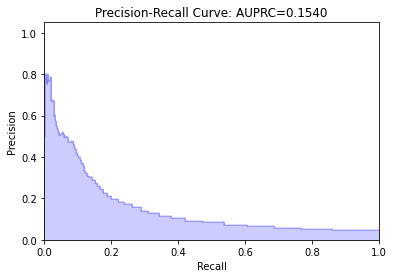

[0.08480329 0.0144563  0.02007419 0.02347888 0.03446456 0.00839994
 0.01238418 0.02171151 0.00110906 0.00205048 0.00423141 0.04428118
 0.02300065 0.00508922 0.00880082 0.00564535 0.0002578  0.00575121
 0.00231894 0.00406386 0.00311811 0.00198434 0.00310158 0.00290951
 0.00293958 0.00253646 0.0027705  0.00134863 0.00590704 0.00189291
 0.0015921  0.00413541 0.00502341 0.00272344 0.00134342 0.00276606
 0.00328056 0.00141527 0.0016434  0.00164739 0.0051054  0.0024344
 0.00252786 0.00281105 0.00636655 0.00459624 0.00358697 0.00103351
 0.00353583 0.00464016 0.00303691 0.00533499 0.00145517 0.00377379
 0.00583886 0.00488239 0.00325862 0.00590835 0.0674321  0.07590704
 0.03767434 0.0403091  0.07828787 0.07614469 0.0836939  0.03955002
 0.05042195]


In [14]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 37.12991905212402 seconds
AUC: 0.6956174947199644
AUPRC: 0.1731506703897967
Sensitivity: 0.5873589164785553
Specificity: 0.6903388769670958
Score thresold: 0.04020764428743692
2.5 97.5


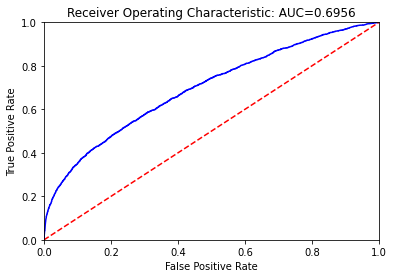

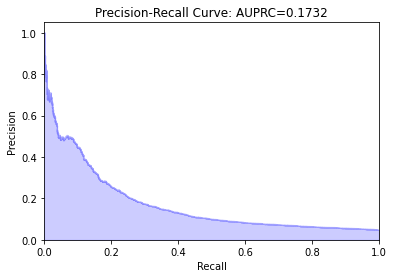

In [15]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [ ]:
print("Med2Vec:")


Med2Vec:


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model

from embedding import *

In [ ]:
version = 'v10'
vocabulary_map = {'v9_3digit':5571, 'v9':5679, 'v10': 7930}
batch_size=200

df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
vocabulary = vocabulary_map[version]
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

icd_train_list = [eval(x) for x in df_train_embed['icd_encoded_list'].copy()]
icd_test_list = [eval(x) for x in df_test_embed['icd_encoded_list'].copy()]
X_train = X_train.to_numpy(dtype=np.float32)
y_train = y_train.to_numpy(dtype=np.float32)
X_test = X_test.to_numpy(dtype=np.float32)
y_test = y_test.to_numpy(dtype=np.float32)

In [ ]:
train_gen = EmbeddingDataGen(X_train, icd_train_list, y_train, batch_size=batch_size)
test_gen = EmbeddingDataGen(X_test, icd_test_list, y_test, batch_size=batch_size)

Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None, 1024)        0           ['embedding_2[0][0]']            
 da)                                                                                              
                                                                                                  
 dense_8 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

2021-12-20 15:41:37.340217: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: embedding_critical_v10/assets
AUC: 0.8433618570603065
AUPRC: 0.3211638706996119
Sensitivity: 0.7773279352226721
Specificity: 0.762668193529917
Score thresold: 0.005310656
2.5 97.5


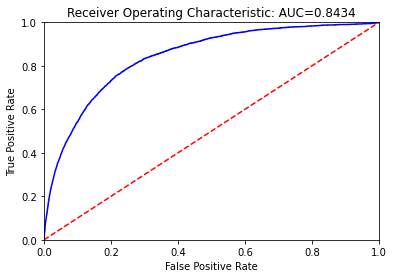

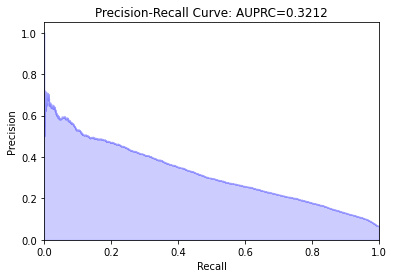

In [ ]:
load_model=False

if load_model:
        model = keras.models.load_model("embedding_critical_"+version)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
keras.models.save_model(model, "embedding_critical_"+version)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [17]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.678253,0.166534,0.568397,0.686449,0.041905,0.665474,0.689144,0.006277,0.149285,0.182099,0.007705,0.544747,0.602108,0.016179,0.655721,0.718638,0.019163,3.124672
1,MLP,0.693274,0.170183,0.632506,0.636199,0.045367,0.681104,0.705132,0.006130,0.153734,0.185053,0.008160,0.574938,0.658130,0.021684,0.612702,0.693368,0.023720,79.100674
2,RF,0.661286,0.154032,0.605418,0.623614,0.043333,0.647025,0.673822,0.006977,0.138824,0.168708,0.007847,0.527313,0.621931,0.032790,0.620726,0.712413,0.042487,34.510735
3,GB,0.695617,0.173151,0.587359,0.690339,0.040208,0.684987,0.708103,0.006090,0.155732,0.188794,0.008043,0.579009,0.660388,0.023561,0.618487,0.698776,0.027229,37.129919


In [18]:
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.678253,0.166534,0.568397,0.686449,0.041905,0.665474,0.689144,0.006277,0.149285,0.182099,0.007705,0.544747,0.602108,0.016179,0.655721,0.718638,0.019163,3.124672
1,MLP,0.693274,0.170183,0.632506,0.636199,0.045367,0.681104,0.705132,0.006130,0.153734,0.185053,0.008160,0.574938,0.658130,0.021684,0.612702,0.693368,0.023720,79.100674
2,RF,0.661286,0.154032,0.605418,0.623614,0.043333,0.647025,0.673822,0.006977,0.138824,0.168708,0.007847,0.527313,0.621931,0.032790,0.620726,0.712413,0.042487,34.510735
3,GB,0.695617,0.173151,0.587359,0.690339,0.040208,0.684987,0.708103,0.006090,0.155732,0.188794,0.008043,0.579009,0.660388,0.023561,0.618487,0.698776,0.027229,37.129919


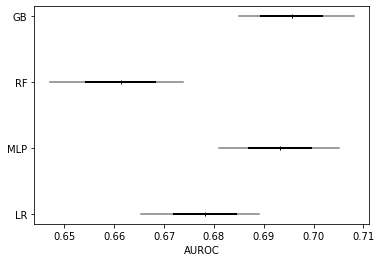

In [20]:
from helpers import plot_confidence_interval
#plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_72h.eps', my_path = output_path) 

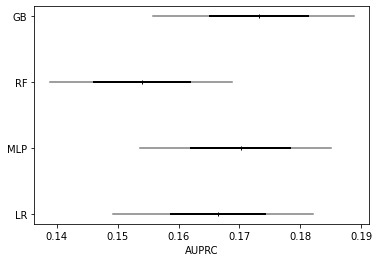

In [21]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_72h.eps', my_path = output_path)

In [ ]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)